In [36]:
#Latent Dirichlet Allocation
#LDA is a generative probabilistic model that assumes
#each topic is a mixture over an underlying set of words
#each document is a mixture of over a set of topic probabilities

In [37]:
import pandas as pd
import os
import re
from wordcloud import WordCloud # Import the wordcloud library
import random
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wenqian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# perform topic modeling

In [39]:
papers = pd.read_csv('papers.csv')

In [40]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [41]:
#focus only on the text data from each paper, and drop other metadata columns
np.random.seed(1)
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)
papers.head()

,year,title,abstract,paper_text
420,1997,The Asymptotic Convergence-Rate of Q-learning,Abstract Missing,The Asymptotic Convergence-Rate of\nQ-Iearning...
3204,2010,Online Learning for Latent Dirichlet Allocation,We develop an online variational Bayes (VB) al...,Online Learning for Latent Dirichlet Allocatio...
4301,2013,A Kernel Test for Three-Variable Interactions,We introduce kernel nonparametric tests for La...,A Kernel Test for Three-Variable Interactions\...
3035,2009,Kernel Choice and Classifiability for RKHS Emb...,Abstract Missing,Kernel Choice and Classifiability for RKHS\nEm...
3443,2010,Occlusion Detection and Motion Estimation with...,We tackle the problem of simultaneously detect...,Occlusion Detection and Motion Estimation\nwit...


In [42]:
## Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))#. , !?
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

<>:2: DeprecationWarning: invalid escape sequence '\.'
<>:2: DeprecationWarning: invalid escape sequence '\.'
/var/folders/4t/w05mrsdn0r9d85szm0g3kg740000gn/T/ipykernel_90913/667358594.py:2: DeprecationWarning: invalid escape sequence '\.'
  papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))#. , !?


420     the asymptotic convergence-rate of\nq-iearning...
3204    online learning for latent dirichlet allocatio...
4301    a kernel test for three-variable interactions\...
3035    kernel choice and classifiability for rkhs\nem...
3443    occlusion detection and motion estimation\nwit...
Name: paper_text_processed, dtype: object

In [43]:
#Exploratory Analysis

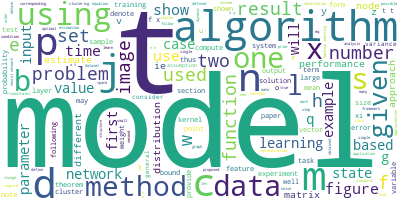

In [44]:
#make a word cloud using the wordcloud package to get a visual representation of most common words

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [45]:
#Prepare data for LDA Analysis

#transform the textual data in a format that will serve as an input for training LDA model
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


def sent_to_words(sentences):
    for sentence in sentences: #a iterable of sentences, transforming each sentence into a list of words
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

In [46]:
print(data_words[:1][0][:30])#[:1] create a new list that only contain first sublist,[0]  accesses this sublist directly

['asymptotic', 'convergence', 'rate', 'iearning', 'es', 'szepesvari', 'research', 'group', 'artificial', 'intelligence', 'jozsef', 'attila', 'university', 'szeged', 'aradi', 'vrt', 'tere', 'hungary', 'szepes', 'mathu', 'szegedhu', 'abstract', 'paper', 'show', 'discounted', 'mdps', 'discount', 'factor', 'asymptotic', 'rate']


In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)#map each unique word to a specific integer ID

# Create Corpus
texts = data_words
# Term Document Frequency；
corpus = [id2word.doc2bow(text) for text in texts] #doc2bow counts the number of occurrences of each word in the document,return (word_id, word_count)

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 13), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (10, 2), (11, 1), (12, 1), (13, 8), (14, 3), (15, 10), (16, 1), (17, 3), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 6)]


In [48]:
#LDA model training
#keep all the parameters to default except for inputting the number of topics

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"data" + 0.006*"model" + 0.005*"learning" + 0.004*"using" + '
  '0.004*"algorithm" + 0.003*"two" + 0.003*"db" + 0.003*"set" + 0.003*"log" + '
  '0.003*"models"'),
 (1,
  '0.006*"data" + 0.006*"model" + 0.005*"function" + 0.005*"learning" + '
  '0.004*"algorithm" + 0.004*"using" + 0.003*"set" + 0.003*"db" + 0.003*"time" '
  '+ 0.003*"xt"'),
 (2,
  '0.007*"learning" + 0.006*"algorithm" + 0.005*"using" + 0.005*"model" + '
  '0.005*"data" + 0.004*"problem" + 0.003*"function" + 0.003*"xi" + 0.003*"ts" '
  '+ 0.003*"one"'),
 (3,
  '0.006*"data" + 0.006*"learning" + 0.005*"algorithm" + 0.004*"function" + '
  '0.004*"using" + 0.004*"set" + 0.004*"model" + 0.003*"training" + '
  '0.003*"used" + 0.003*"two"'),
 (4,
  '0.006*"model" + 0.006*"data" + 0.005*"algorithm" + 0.005*"learning" + '
  '0.003*"training" + 0.003*"one" + 0.003*"models" + 0.003*"based" + '
  '0.003*"using" + 0.003*"network"'),
 (5,
  '0.007*"data" + 0.006*"learning" + 0.006*"model" + 0.005*"algorithm" + '
  '0.00

In [49]:
#each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic

In [50]:
#Set up a Path for Saving
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))#the number of topics (num_topics) in the filename

os.makedirs(os.path.dirname(LDAvis_data_filepath), exist_ok=True)

In [51]:
#Analyzing LDA model results
#visualize the topics for interpretability
#interpreting individual topics and the relationships between the topics

# Visualize the topics
pyLDAvis.enable_notebook() #activates pyLDAvis within a Jupyter notebook environment

#Prepare the Visualization Data
if 1 == 1: ## This condition is always true; it's used here likely for easy toggling of execution.
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

#Save the Interactive Visualization as an HTML File
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

#return Visualization
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.003386 -0.006599       1        1  23.393263
5      0.000694 -0.010534       2        1  19.083455
1      0.009372  0.003769       3        1  15.021864
6      0.009270 -0.000590       4        1  10.528071
9      0.000171  0.003143       5        1   8.916004
2     -0.007818  0.001452       6        1   7.315128
0     -0.003266  0.001503       7        1   6.106422
3     -0.001552  0.001912       8        1   3.952247
8      0.000706 -0.000259       9        1   3.146066
4     -0.004193  0.006203      10        1   2.537480, topic_info=             Term         Freq        Total Category  logprob  loglift
332         model  1311.000000  1311.000000  Default  30.0000  30.0000
283      learning  1295.000000  1295.000000  Default  29.0000  29.0000
752          data  1447.000000  1447.000000  Default  28.0000  28.0000
14      algorithm  1135.000000  1135.000000  Default  27.0000  27.0000
571         using   900.000000   900.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
192      function    14.050902   881.906310  Topic10  -6.0318  -0.4654
135  distribution    12.350749   605.885735  Topic10  -6.1608  -0.2190
295           log    12.148185   633.884105  Topic10  -6.1773  -0.2807
198         given    12.158163   644.269575  Topic10  -6.1765  -0.2961
17           also    11.598236   578.198216  Topic10  -6.2236  -0.2351

[863 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7840      1  0.402870  acausal
7840      2  0.134290  acausal
7840      6  0.134290  acausal
7840      7  0.134290  acausal
4         1  0.182024  actions
...     ...       ...      ...
9734      4  0.287804      ztj
7998      1  0.460754       zy
7998      2  0.153585       zy
7998      6  0.153585       zy
7998      7  0.153585       zy

[3630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 2, 7, 10, 3, 1, 4, 9, 5])